In [ ]:
pip install arviz

In [ ]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import arviz
import pickle
import cmdstanpy
import json
import copy
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/TFM-Crowd learning/multinomial.json') as json_file:
    data = json.load(json_file)

In [ ]:
dades={'Tasca': data['t_A'], 'Worker': data['w_A'], 'Anotació': data['ann'] }
df = pd.DataFrame(data=dades)
df

,Tasca,Worker,Anotació
0,0,14,2
1,0,13,2
2,0,4,2
3,0,2,2
4,0,7,1
...,...,...,...
9995,999,17,2
9996,999,2,2
9997,999,13,2
9998,999,14,2


In [ ]:
sm_general = pystan.StanModel(file='/content/drive/MyDrive/TFM-Crowd learning/Fitxers STAN/general_dawid-skene.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3b91d5d08ea08e32e8380bfec8b2a00 NOW.


In [ ]:
w = len(np.unique(df['Worker']))
t = len(np.unique(df['Tasca']))
a = len(df['Anotació'])
k = len(np.unique(df['Anotació']))
t_A = np.array(df['Tasca'])+1
w_A = np.array(df['Worker'])+1
ann = np.array(df['Anotació'])+1
tau_prior = np.array([1,1,1])
pi_prior = np.ones((k,k))

dades_sm_gen = {'w':w,'t':t,'a':a,'k':k,'t_A':t_A,'w_A':w_A,'ann':ann,'tau_prior':tau_prior,'pi_prior':pi_prior} 

In [ ]:
pi_ini = np.zeros((w,k,k))
for yw in range(w):
  pi_ini[yw] = np.eye(k)+0.05
  pi_ini[yw] /= np.sum(pi_ini[yw],axis=1)
dades_inicials_gen = {'pi':pi_ini}

In [ ]:
optim = sm_general.optimizing(data=dades_sm_gen,init=dades_inicials_gen)
optim

OrderedDict([('tau', array([0.11256323, 0.29707964, 0.59035713])),
             ('pi', array([[[0.85027659, 0.07914737, 0.07057604],
                      [0.21906133, 0.58875925, 0.19217942],
                      [0.1476537 , 0.09129954, 0.76104676]],
              
                     [[0.65431339, 0.12650252, 0.21918408],
                      [0.30767495, 0.51726491, 0.17506014],
                      [0.13057251, 0.11073493, 0.75869256]],
              
                     [[0.62403074, 0.08480038, 0.29116888],
                      [0.21373934, 0.60220277, 0.18405789],
                      [0.07408976, 0.10848996, 0.81742028]],
              
                     [[0.69219445, 0.09323169, 0.21457387],
                      [0.19745929, 0.63425792, 0.16828279],
                      [0.09578127, 0.1382563 , 0.76596243]],
              
                     [[0.55516061, 0.16265626, 0.28218313],
                      [0.22259636, 0.63069604, 0.1467076 ],
                      [

In [ ]:
sm_gener_data = pystan.StanModel(file='/content/drive/MyDrive/TFM-Crowd learning/Fitxers STAN/generate_data.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8251fcac44b8988cc03b6a3bfb75909e NOW.


In [ ]:
sm_pooled_mult = pystan.StanModel(file='/content/drive/MyDrive/TFM-Crowd learning/Fitxers STAN/Multinomial.fit_and_consensus.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_eb22c1a71e18909250dd5ae3d1ee0693 NOW.


In [ ]:
import random 
from scipy.stats import entropy

def generate_new_data(opt,k):
  results = opt['ann']-1
  results=np.where(results<0,np.nan,results)
  diction = {}
  for i in range(k):
    diction["where_{0}_task".format(i)] = np.where(results==i)[0]
    diction["where_{0}_worker".format(i)] = np.where(results==i)[1]
    diction["annotation_{0}".format(i)] = np.full(len(diction["where_{0}_task".format(i)]), fill_value=i, dtype = np.int)
  tasks_col = np.concatenate([diction["where_{0}_task".format(i)] for i in range(k)])
  workers_col = np.concatenate([diction["where_{0}_worker".format(i)] for i in range(k)])
  annotatios_col = np.concatenate([diction["annotation_{0}".format(i)] for i in range(k)])
  d = {'Tasca': tasks_col, 'Worker': workers_col, 'Anotació':annotatios_col}
  return pd.DataFrame(d).sort_values(by='Tasca')


def majority_voting(dataframe):
  a = len(np.unique(dataframe['Tasca']))
  tc = []
  for i in range(0,a):
    annotations = np.array(dataframe[dataframe['Tasca']==i]['Anotació'])
    tc.append(np.argmax(np.bincount(annotations)))
  return np.array(tc)


def generate_permutation(perm):
    l=list(perm)
    uniques=[k for k in l if l.count(k)==1]
    if len(uniques)==len(l): 
      return np.array(l)
    existing=list(set(l))
    rank=list(range(len(l)))
    missing=[x for x in rank if x not in existing]
    corrected=[]
    for k in range(len(l)):
        if l[k] not in uniques:
            if l[k] not in corrected:
                if l[l[k]]==l[k]:
                    if k!=l[k]:
                        l[k]=missing[0]
                        missing.pop(0)
                    else:
                        corrected.append(l[k])
                else:
                    corrected.append(l[k])
            else:
                l[k]=missing[0]
                missing.pop(0)
        else:
          continue
    return np.array(l)

def pipeline(t,ann_per_task,tau,pi,tau_prior,pi_prior,sm_generate = sm_gener_data,sm2 = sm_general, sm3 = sm_pooled_mult, algorithm = "LBFGS" ):
  w = pi.shape[0]
  k = pi.shape[1]
  workers_random_order = []
  for i in range(t):
    workers=np.arange(1,w+1)
    random.shuffle(workers)
    workers_random_order.append(workers)
  data_to_pass = {'w':w,'t':t,'k':k,'tau':tau,'ann_per_task':ann_per_task,'workers_random_order':workers_random_order,'pi':pi} 
  generated_data = sm_generate.optimizing(data=data_to_pass)
  generated_data_df = generate_new_data(generated_data,k)
  a = len(generated_data_df['Anotació'])
  t_A = np.array(generated_data_df['Tasca'])+1
  w_A = np.array(generated_data_df['Worker'])+1
  ann = np.array(generated_data_df['Anotació'])+1
  data_to_pass_2 = {'w':w,'t':t,'a':a,'k':k,'t_A':t_A,'w_A':w_A,'ann':ann,'tau_prior':tau_prior,'pi_prior':pi_prior} 
  
  #we apply pooled multinomial for obtaining initial points
  tc_majority_voting = majority_voting(generated_data_df)
  initial_tau = np.unique(tc_majority_voting,return_counts=True)[1]/sum(np.unique(tc_majority_voting,return_counts=True)[1])
  initial_points = {'tau':initial_tau}
  pooled_results = sm3.optimizing(data=data_to_pass_2,init=initial_points,algorithm = algorithm)
  
  pi_init = np.zeros((w,k,k))
  for i in range(w):
    pi_init[i] += pooled_results['pi']

  init_points_2 = {'tau':pooled_results['tau'],'pi':pi_init}
  params = sm2.optimizing(data=data_to_pass_2,init = init_points_2, algorithm = algorithm )
  return params

def kullback_leibler_tau(tau_init,tau_hat):
  entrop = entropy(pk = tau_init, qk = tau_hat)
  if entrop == np.nan or entrop == np.inf: #should never enter here
    return 100 
  else:
    return entrop

def kullback_leibler_pi(pi_init,pi_hat):
  KL_values = []
  for i in range(len(pi_init)):
    entrop = entropy(pk = pi_init[i], qk = pi_hat[i])
    if np.isinf(entrop).all() ==True or np.isnan(entrop).all()==True:  #should never enter here
      continue
    KL_values.append(np.nanmax(entrop[entrop != np.inf]))
  
  if not KL_values: #if array is empty
    return 100 #case where it has worked horrible, should never enter here
  else:
    return np.nanmedian(KL_values)


def correct_label_switching(tau,pi):
  acumulacio_permutacions=[]

  new_pi = copy.deepcopy(pi)
  new_tau = copy.deepcopy(tau)


  for w in range(len(pi)):
    on_hauria_danar = np.argmax(pi[w],axis=1)
    acumulacio_permutacions.append(on_hauria_danar)

  #we determine the winner permutation in order to apply it to tau and pi
  values, counts = np.unique(acumulacio_permutacions,axis=0, return_counts=True)
  ind = np.argmax(counts)
  permutacio = values[ind]

  #fix (if necessary) the obtained permutation (the result is an array!)
  good_permutation = generate_permutation(permutacio)

  #update pi
  for w in range(len(pi)):
    new_pi[w,good_permutation,:] = pi[w,np.arange(len(pi[w])),:]

  #update tau
  for i in range(len(tau)):
    new_tau[good_permutation[i]] = tau[i]

  return new_tau,new_pi


def get_KL_values(tau,pi,exp):
  exps =  copy.deepcopy(exp)
  tau_hat = exps['tau']
  pi_hat = exps['pi']
  KL_tau_no_LS = kullback_leibler_tau(tau,tau_hat)
  KL_pi_no_LS = kullback_leibler_pi(pi,pi_hat)
  new_tau_hat,new_pi_hat = correct_label_switching(tau_hat,pi_hat)
  KL_tau_LS = kullback_leibler_tau(tau,new_tau_hat)
  KL_pi_LS = kullback_leibler_pi(pi,new_pi_hat)
  return KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS

def experiment_repetition(t,ann_per_task,tau,pi,tau_prior,pi_prior,num_repetitions=500, algorithm = "LBFGS"):
  KL_tau_no_LS_values=[]
  KL_pi_no_LS_values=[]
  KL_tau_LS_values=[]
  KL_pi_LS_values=[]
  for i in range(num_repetitions):
    exp = pipeline(t,ann_per_task,tau,pi,tau_prior,pi_prior,algorithm=algorithm)
    KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS = get_KL_values(tau,pi,exp)
    KL_tau_no_LS_values.append(KL_tau_no_LS)
    KL_pi_no_LS_values.append(KL_pi_no_LS)
    KL_tau_LS_values.append(KL_tau_LS)
    KL_pi_LS_values.append(KL_pi_LS)
  return KL_tau_no_LS_values,KL_pi_no_LS_values,KL_tau_LS_values,KL_pi_LS_values



## Diagonal dominant

In [ ]:
#PIPELINE CELL
k=4

tau_prior = np.full(shape=k,fill_value=1)
pi_prior = np.ones((k,k))
tau = np.random.dirichlet([30,30,30,30])
num_workers=100
pi = np.zeros((num_workers,k,k))

for w in range(num_workers):
  matriu_randoms_dirichlet = np.array([[75+random.randint(-5,5),12,12,12],
                                      [12,75+random.randint(-5,5),12,12],
                                      [12,12,75+random.randint(-5,5),12],
                                      [12,12,12,75+random.randint(-5,5)]])
  for i in range(k):
    pi[w][i] += np.random.dirichlet(matriu_randoms_dirichlet[i])

KL_tau_no_LS_values=[]
KL_pi_no_LS_values=[]
KL_tau_LS_values=[]
KL_pi_LS_values=[]


for i in range(6,62,2):
  print(i)
  KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS= experiment_repetition(t=500,ann_per_task=i,tau=tau,pi=pi,tau_prior = tau_prior,pi_prior=pi_prior)
  KL_tau_no_LS_values.append(KL_tau_no_LS)
  KL_pi_no_LS_values.append(KL_pi_no_LS)
  KL_tau_LS_values.append(KL_tau_LS)
  KL_pi_LS_values.append(KL_pi_LS)

KL_tau_no_LS_values = np.array(KL_tau_no_LS_values)
KL_pi_no_LS_values = np.array(KL_pi_no_LS_values)
KL_tau_LS_values = np.array(KL_tau_LS_values)
KL_pi_LS_values = np.array(KL_pi_LS_values)

print(KL_tau_no_LS_values.shape)
print(KL_pi_no_LS_values.shape)
print(KL_tau_LS_values.shape)
print(KL_pi_LS_values.shape)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
(28, 500)
(28, 500)
(28, 500)
(28, 500)


In [ ]:
#save values in txt file
file_KL_tau_no_LS_values = open("diagonal_dom_100_workers_tau_dirichlet_30_KL_tau_no_LS_values.txt", "w")
for row in KL_tau_no_LS_values:
  np.savetxt(file_KL_tau_no_LS_values, row)

file_KL_tau_no_LS_values.close()

file_KL_pi_no_LS_values = open("diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_no_LS_values.txt", "w")
for row in KL_pi_no_LS_values:
  np.savetxt(file_KL_pi_no_LS_values, row)

file_KL_pi_no_LS_values.close()


file_KL_tau_LS_values = open("diagonal_dom_100_workers_tau_dirichlet_30_tau_LS_values.txt", "w")
for row in KL_tau_LS_values:
  np.savetxt(file_KL_tau_LS_values, row)

file_KL_tau_LS_values.close()

file_KL_pi_LS_values = open("diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_LS_values.txt", "w")
for row in KL_pi_LS_values:
  np.savetxt(file_KL_pi_LS_values, row)

file_KL_pi_LS_values.close()


In [ ]:
from google.colab import files
files.download('diagonal_dom_100_workers_tau_dirichlet_30_KL_tau_no_LS_values.txt')
files.download('diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_no_LS_values.txt')
files.download('diagonal_dom_100_workers_tau_dirichlet_30_tau_LS_values.txt')
files.download('diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_LS_values.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#to recover the arrays from the txt files, compile this:
#FOR THE SHAPES, SEE THE prints from the pipeline CELL
original_KL_tau_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_100_workers_tau_dirichlet_30_KL_tau_no_LS_values.txt").reshape(28, 500)
original_KL_pi_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_no_LS_values.txt").reshape(28,500)
original_KL_tau_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_100_workers_tau_dirichlet_30_tau_LS_values.txt").reshape(28,500)
original_KL_pi_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_100_workers_tau_dirichlet_30_KL_pi_LS_values.txt").reshape(28,500)

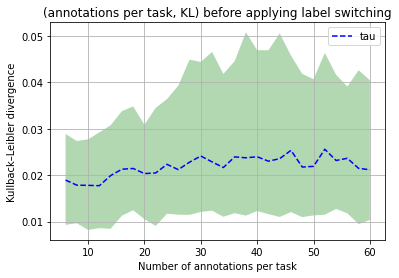

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_no_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau BEFORE LS', np.mean(np.nanmedian(KL_tau_no_LS_values,axis=1)))

Mean value of the KL values for tau BEFORE LS 0.02190074790847511


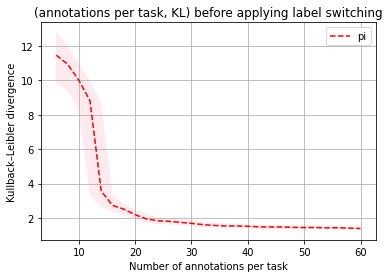

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_no_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi BEFORE LS', np.mean(np.nanmedian(KL_pi_no_LS_values,axis=1)))

Mean value of the KL values for pi BEFORE LS 2.9783542398373366


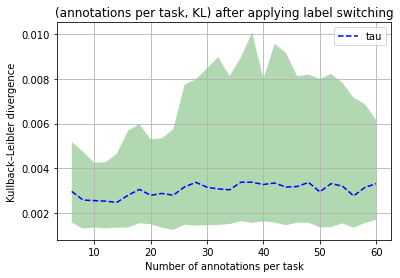

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_LS_values, 25,axis=1),y2=np.percentile(KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau AFTER LS', np.mean(np.nanmedian(KL_tau_LS_values,axis=1)))

Mean value of the KL values for tau AFTER LS 0.0030415956846956307


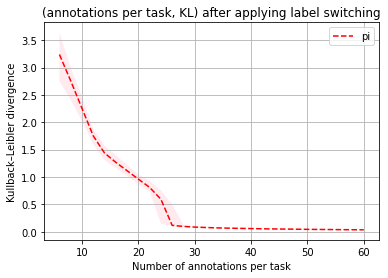

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_LS_values, 25,axis=1),y2=np.percentile(KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi AFTER LS', np.mean(np.nanmedian(KL_pi_LS_values,axis=1)))

Mean value of the KL values for pi AFTER LS 0.6153906938641663


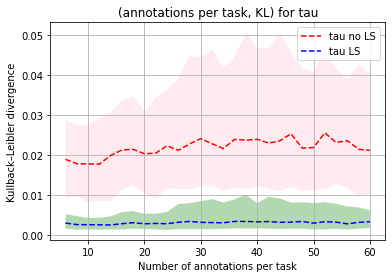

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)

plt.plot(annots_x_task,np.nanmedian(original_KL_tau_no_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_LS_values,axis=1),'b--')

plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) for tau')
plt.legend(['tau no LS','tau LS'])


ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

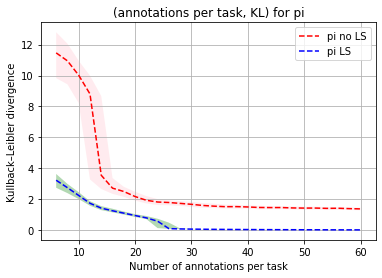

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=60+2,step=2)
ax = plt.subplot()
plt.grid(True)

plt.plot(annots_x_task,np.nanmedian(original_KL_pi_no_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_LS_values,axis=1),'b--')

plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) for pi')
plt.legend(['pi no LS','pi LS'])


ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

## tau unbalanced 

In [ ]:
#PIPELINE CELL
k=4

tau_prior = np.full(shape=k,fill_value=1)
pi_prior = np.ones((k,k))
tau = np.random.dirichlet([75,random.randint(10,15),random.randint(10,15),random.randint(10,15)])
num_workers=36
pi = np.zeros((num_workers,k,k))

for w in range(num_workers):
  matriu_randoms_dirichlet = np.array([[70+random.randint(-5,5),12,12,12],
                                      [12,70+random.randint(-5,5),12,12],
                                      [12,12,70+random.randint(-5,5),12],
                                      [12,12,12,70+random.randint(-5,5)]])
  for i in range(k):
    pi[w][i] += np.random.dirichlet(matriu_randoms_dirichlet[i])


KL_tau_no_LS_values=[]
KL_pi_no_LS_values=[]
KL_tau_LS_values=[]
KL_pi_LS_values=[]

for i in range(8,num_workers+2,2):
  print(i)
  KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS  = experiment_repetition(t=1000,ann_per_task=i,tau=tau,pi=pi,tau_prior = tau_prior,pi_prior=pi_prior,num_repetitions=400)
  KL_tau_no_LS_values.append(KL_tau_no_LS)
  KL_pi_no_LS_values.append(KL_pi_no_LS)
  KL_tau_LS_values.append(KL_tau_LS)
  KL_pi_LS_values.append(KL_pi_LS)

KL_tau_no_LS_values = np.array(KL_tau_no_LS_values)
KL_pi_no_LS_values = np.array(KL_pi_no_LS_values)
KL_tau_LS_values = np.array(KL_tau_LS_values)
KL_pi_LS_values = np.array(KL_pi_LS_values)


print(KL_tau_no_LS_values.shape)
print(KL_pi_no_LS_values.shape)
print(KL_tau_LS_values.shape)
print(KL_pi_LS_values.shape)



In [ ]:
#save values in txt file
file_KL_tau_no_LS_values = open("diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_tau_no_LS_values.txt", "w")
for row in KL_tau_no_LS_values:
  np.savetxt(file_KL_tau_no_LS_values, row)

file_KL_tau_no_LS_values.close()

file_KL_pi_no_LS_values = open("diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_no_LS_values.txt", "w")
for row in KL_pi_no_LS_values:
  np.savetxt(file_KL_pi_no_LS_values, row)

file_KL_pi_no_LS_values.close()


file_KL_tau_LS_values = open("diagonal_dom_36_workers_1000_tasks_tau_unbalanced_tau_LS_values.txt", "w")
for row in KL_tau_LS_values:
  np.savetxt(file_KL_tau_LS_values, row)

file_KL_tau_LS_values.close()

file_KL_pi_LS_values = open("diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_LS_values.txt", "w")
for row in KL_pi_LS_values:
  np.savetxt(file_KL_pi_LS_values, row)

file_KL_pi_LS_values.close()


In [ ]:
from google.colab import files
files.download('diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_tau_no_LS_values.txt')
files.download('diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_no_LS_values.txt')
files.download('diagonal_dom_36_workers_1000_tasks_tau_unbalanced_tau_LS_values.txt')
files.download('diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_LS_values.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#to recover the arrays from the txt files, compile this:
#FOR THE SHAPES, SEE THE prints from the pipeline CELL
original_KL_tau_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_tau_no_LS_values.txt").reshape(15,400)
original_KL_pi_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_no_LS_values.txt").reshape(15,400)
original_KL_tau_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_36_workers_1000_tasks_tau_unbalanced_tau_LS_values.txt").reshape(15,400)
original_KL_pi_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/diagonal_dom_36_workers_1000_tasks_tau_unbalanced_KL_pi_LS_values.txt").reshape(15,400)

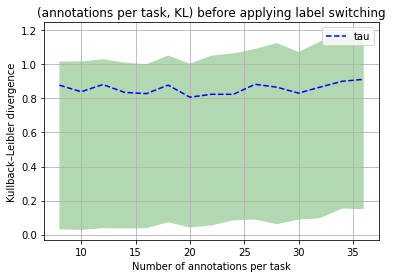

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=num_workers+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_no_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau BEFORE LS', np.mean(np.nanmedian(KL_tau_no_LS_values,axis=1)))

Mean value of the KL values for tau BEFORE LS 0.8575249819239195


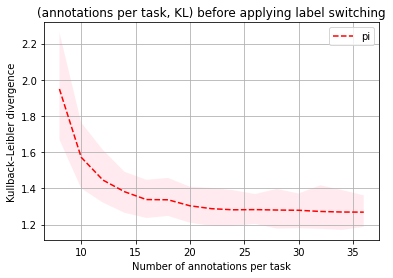

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=num_workers+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_no_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi BEFORE LS', np.mean(np.nanmedian(KL_pi_no_LS_values,axis=1)))

Mean value of the KL values for pi BEFORE LS 1.3700391796017848


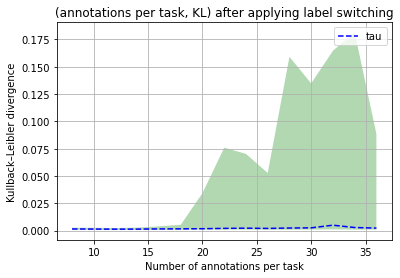

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=num_workers+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_LS_values, 25,axis=1),y2=np.percentile(KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau AFTER LS', np.mean(np.nanmedian(KL_tau_LS_values,axis=1)))

Mean value of the KL values for tau AFTER LS 0.0021489831176470177


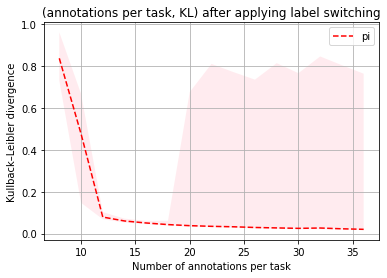

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=num_workers+2,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_LS_values, 25,axis=1),y2=np.percentile(KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi AFTER LS', np.mean(np.nanmedian(KL_pi_LS_values,axis=1)))

Mean value of the KL values for pi AFTER LS 0.12015396765919784


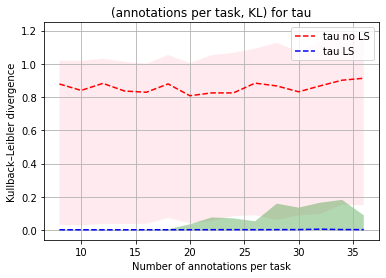

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)

plt.plot(annots_x_task,np.nanmedian(original_KL_tau_no_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_LS_values,axis=1),'b--')

plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) for tau')
plt.legend(['tau no LS','tau LS'])


ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

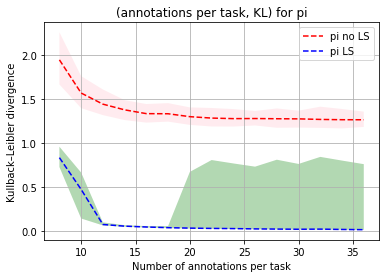

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=8,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)

plt.plot(annots_x_task,np.nanmedian(original_KL_pi_no_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_LS_values,axis=1),'b--')

plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) for pi')
plt.legend(['pi no LS','pi LS'])


ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()